# New York Transit
*Thinkful Presentation by Kalika Kay Curry*

One of the most compelling things about a city is a reliable transit system. Having a public transportation system that can get individuals to their desitinations in a timely manner is of considerable importance and in situations, such as bus transportation; the timeline is even more important as riders strive to meet bus connections.  

Taking a look at the [New York Transport](https://www.kaggle.com/stoney71/new-york-city-transport-statistics/notebooks) dataset that is available on Kaggle, I use two different unsupervised learning models to investigate the reliability of the New York City bus transit system in December of 2017.

In [33]:
#import files
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
import datetime
import random
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d

There are four datasets available on Kaggle. I have chosen the dataset from December 2017, labeled mca_2017. The original dataset consists of over 6 million records. 

This data has been sampled to a fraction at 0.17 and exported to a csv file for convenience which has been uploaded onto GitHub's LFS server, as it is too large to store on GitHub.

In [2]:
#open the dataset.
transit = pd.read_csv("https://media.githubusercontent.com/media/KalikaKay/ny_transit/main/data/sample_mta_1712.csv", low_memory=False)
transit.shape

(1033880, 17)

In [3]:
transit.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocationLat,VehicleLocationLong,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-12-18 06:14:02,NaN,M15,NaN,NaN,NaN,EAST HARLEM 125 ST via 1 AV,NaN,NaN,NYCT_6055,40.802503,-73.930880,NaN,approaching,137,2017-12-18 06:14:48,NaN
1,2017-12-21 04:59:08,1.0,Bx15,3 AV/E FORDHAM RD,40.860630,-73.890797,W. HARLEM 12 AV via 3 AV via 125 ST,40.817913,-73.960168,NYCT_5955,40.807988,-73.946022,W 125 ST/ADAM C POWELL BL,< 1 stop away,270,2017-12-21 05:00:00,04:53:40
2,2017-12-05 11:53:58,0.0,S52,UNIVERSITY DRIVE/MEDICAL ARTS PAV E,40.586937,-74.086418,ST GEORGE FERRY,40.643570,-74.073225,NYCT_8210,40.586113,-74.084216,SEAVIEW AV/E ENT PSYCH CTR,< 1 stop away,492,2017-12-05 11:59:33,12:02:13
3,2017-12-03 13:50:23,0.0,Bx12-SBS,BROADWAY/ISHAM ST,40.868075,-73.919807,SELECT BUS BAY PLAZA CO-OP CITY,40.865666,-73.827623,NYCT_5780,40.868095,-73.919816,BROADWAY/ISHAM ST,at stop,0,NaN,13:52:00
4,2017-12-06 15:37:51,1.0,B6,LIVONIA AV/ASHFORD ST,40.666382,-73.883617,LTD BENSONHURST HARWAY AV,40.592947,-73.993383,NYCT_5103,40.632916,-73.952878,BEDFORD AV/CAMPUS ROAD,approaching,105,2017-12-06 15:38:33,15:33:38


In [715]:
#How often is the bus on time?
pie_chart = transit.loc[(transit.DistanceFromStop == '0')| (transit.DistanceFromStop == 'at stop')].copy()
pie_time = pd.DatetimeIndex(pie_chart.RecordedAtTime)

#track of the date. 
pie_chart['RecordDate'] = pie_time.strftime('%Y-%m-%d ')

#time correction.
sTimes = pie_chart[['ScheduledArrivalTime', 'RecordDate']].loc[pie_chart.ScheduledArrivalTime >= "24"]

#year-month-day as string
ymd = sTimes.RecordDate
hours = sTimes.ScheduledArrivalTime.str[0:2]
rest = sTimes.ScheduledArrivalTime.str[2:]
# subtract 24
hours = hours.astype(int) - 24
# reassign the string
converted = hours.astype(str) + rest
converted = ymd + converted
# make it datetime, adding one to the day because it's after midnight. 
converted = pd.to_datetime(converted, format = '%Y-%m-%d %H:%M:%S')
converted = converted

#scheduled column as Scheduled arrival time converted to date time.
pie_chart['scheduled'] = pd.to_datetime(pie_chart['RecordDate'] + pie_chart['ScheduledArrivalTime'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
pie_chart['scheduled'].fillna(value=converted, inplace=True)

#correct for situations after midnight. 
condition = (pie_chart.scheduled - pie_chart.RecordedAtTime).astype('timedelta64[m]') >= 1000
pie_chart.loc[condition, ['scheduled']] = pie_chart.loc[condition, ['scheduled']] - pd.Timedelta(days=1)

condition = (pie_chart.scheduled - pie_chart.RecordedAtTime).astype('timedelta64[m]') <= -1000
pie_chart.loc[condition, ['scheduled']] = pie_chart.loc[condition, ['scheduled']] + pd.Timedelta(days=1)

#late indicator
condition = (pie_chart.scheduled - pie_chart.RecordedAtTime).astype('timedelta64[m]') < 0
pie_chart['blate'] = condition

#Look at it
pie_chart[['scheduled', 'RecordedAtTime', 'blate']]



,scheduled,RecordedAtTime,blate
3,2017-12-03 13:52:00,2017-12-03 13:50:23,False
9,2017-12-09 15:26:57,2017-12-09 15:31:48,True
19,2017-12-11 18:26:00,2017-12-11 18:25:16,False
33,2017-12-16 20:12:42,2017-12-16 20:11:39,False
39,2017-12-18 12:49:00,2017-12-18 12:54:56,True
...,...,...,...
1033840,2017-12-03 16:12:34,2017-12-03 16:20:47,True
1033850,2017-12-25 15:50:14,2017-12-25 15:44:57,False
1033855,2017-12-11 14:09:00,2017-12-11 14:06:07,False
1033864,2017-12-14 17:14:00,2017-12-14 17:11:46,False


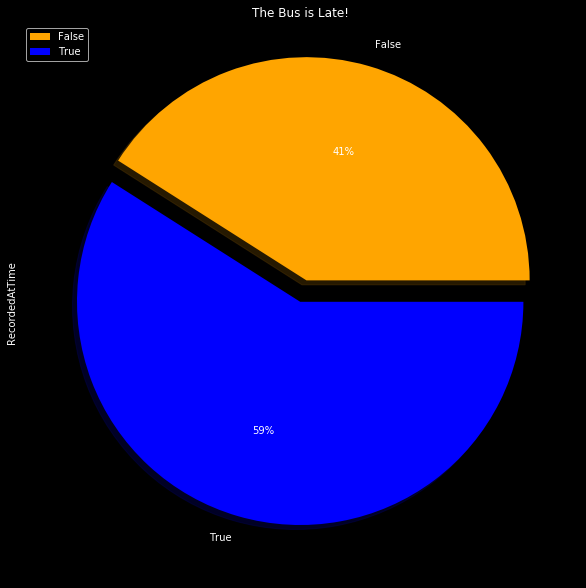

In [752]:
colors = ['orange', 'blue']
pie = pie_chart.groupby(by='blate').agg('count')
pie.plot.pie(y='RecordedAtTime', figsize=(10,14), autopct='%.0f%%', colors=colors, explode=(0.1, 0), shadow=True)
plt.title("The Bus is Late!")
plt.show()

# Data Exploration

An investigation of the data.

In [4]:
#A summary of missing variables represented as a percentage of the total missing content. 
def missingness_summary(df, print_log=False, sort='ascending'):
  s = df.isnull().sum()*100/df.isnull().count()
    
  if sort.lower() == 'ascending':
    s = s.sort_values(ascending=True)
  elif sort.lower() == 'descending':
    s = s.sort_values(ascending=False)  
  if print_log: 
    print(s)
  
  return pd.Series(s)

In [5]:
#A report to work from when doing data exploration.
def de_report(df):
    #A dataframe containing data for reports - of missing values, datatypes and unique values for all columns.
    summary = missingness_summary(df)
    report = pd.concat([summary.rename('nullCount'), df.dtypes.reindex(summary.index).rename('dType')], join='inner', axis=1)
    report = pd.concat([report, df.nunique().reindex(summary.index).rename('nUnique')], join='inner', axis=1)
    return report

In [6]:
#Transit's column report. 
rep = de_report(transit)
rep

,nullCount,dType,nUnique
RecordedAtTime,0.000000,object,157000
PublishedLineName,0.000000,object,328
DestinationName,0.000000,object,802
VehicleLocationLong,0.000000,float64,282113
VehicleLocationLat,0.000000,float64,285352
VehicleRef,0.000000,object,5670
DistanceFromStop,0.107846,object,8452
ArrivalProximityText,0.107846,object,208
DirectionRef,4.658084,float64,2
NextStopPointName,4.762352,object,10229


In [7]:
#These are columns that don't contain nulls. 
de_report(transit[["RecordedAtTime", 'DestinationName', 'VehicleRef', 'VehicleLocationLat', 'VehicleLocationLong']])

,nullCount,dType,nUnique
RecordedAtTime,0.0,object,157000
DestinationName,0.0,object,802
VehicleRef,0.0,object,5670
VehicleLocationLat,0.0,float64,285352
VehicleLocationLong,0.0,float64,282113


In [8]:
#Invetigate the objects.
transit[["RecordedAtTime", 'DestinationName', 'VehicleRef']].head(4)

,RecordedAtTime,DestinationName,VehicleRef
0,2017-12-18 06:14:02,EAST HARLEM 125 ST via 1 AV,NYCT_6055
1,2017-12-21 04:59:08,W. HARLEM 12 AV via 3 AV via 125 ST,NYCT_5955
2,2017-12-05 11:53:58,ST GEORGE FERRY,NYCT_8210
3,2017-12-03 13:50:23,SELECT BUS BAY PLAZA CO-OP CITY,NYCT_5780


In [9]:
#Converting categorical values at this stage so this information is accessible later.
#label encode the categorical columns.
lb_make = LabelEncoder()
transit['destination'] = lb_make.fit_transform(transit["DestinationName"])
transit[["destination", "DestinationName"]].head(11)

,destination,DestinationName
0,204,EAST HARLEM 125 ST via 1 AV
1,750,W. HARLEM 12 AV via 3 AV via 125 ST
2,696,ST GEORGE FERRY
3,637,SELECT BUS BAY PLAZA CO-OP CITY
4,442,LTD BENSONHURST HARWAY AV
5,788,WILLIAMSBURG BRIDGE PLZ
6,785,WILLIAMSBRIDGE GUN HILL RD via WEBSTER
7,213,EAST NEW YORK EUCLID AV STA via ROCKAWAY BL
8,640,SELECT BUS BRONX ZOO via MAIN ST
9,350,JAMAICA LIRR STA via HILLSDE


In [10]:
#label encode the categorical columns.
transit['vehicle'] = lb_make.fit_transform(transit["VehicleRef"])
transit[["vehicle", "VehicleRef"]].head(11)

,vehicle,VehicleRef
0,3858,NYCT_6055
1,3774,NYCT_5955
2,5374,NYCT_8210
3,3601,NYCT_5780
4,3178,NYCT_5103
5,4692,NYCT_7193
6,5492,NYCT_8329
7,892,MTABC_4652
8,3830,NYCT_6013
9,4435,NYCT_6873


In [11]:
#Convert the date/time object to one date column and one time column.
transit['RecordedAtTime'] = pd.to_datetime(transit['RecordedAtTime'])
de_report(transit)

,nullCount,dType,nUnique
RecordedAtTime,0.000000,datetime64[ns],157000
VehicleLocationLong,0.000000,float64,282113
VehicleLocationLat,0.000000,float64,285352
destination,0.000000,int32,802
DestinationName,0.000000,object,802
VehicleRef,0.000000,object,5670
PublishedLineName,0.000000,object,328
vehicle,0.000000,int32,5670
ArrivalProximityText,0.107846,object,208
DistanceFromStop,0.107846,object,8452


In [12]:
#Assign a RecordTime columns equal to the minutes of the day that it was recorded. Round to the nearest fifteen minute mark. 
time = pd.DatetimeIndex(transit['RecordedAtTime']).round('15min')
time = time.hour * 60 + time.minute
transit['recordtime'] = time

In [13]:
transit['recordtime']

0           375
1           300
2           720
3           825
4           945
           ... 
1033875     960
1033876     405
1033877     795
1033878    1410
1033879     270
Name: recordtime, Length: 1033880, dtype: int64

In [14]:
#Assign a Record Day
transit['recordday'] = pd.DatetimeIndex(transit['RecordedAtTime']).day
transit['recordday']

0          18
1          21
2           5
3           3
4           6
           ..
1033875    19
1033876    28
1033877    23
1033878    12
1033879     6
Name: recordday, Length: 1033880, dtype: int64

# Data Cleaning

In [15]:
#columns to use with dataframe for cleaning.
cols = ["recordday", 'recordtime', 'destination', 'vehicle', 'VehicleLocationLat', 'VehicleLocationLong']
transport = transit[cols].copy()

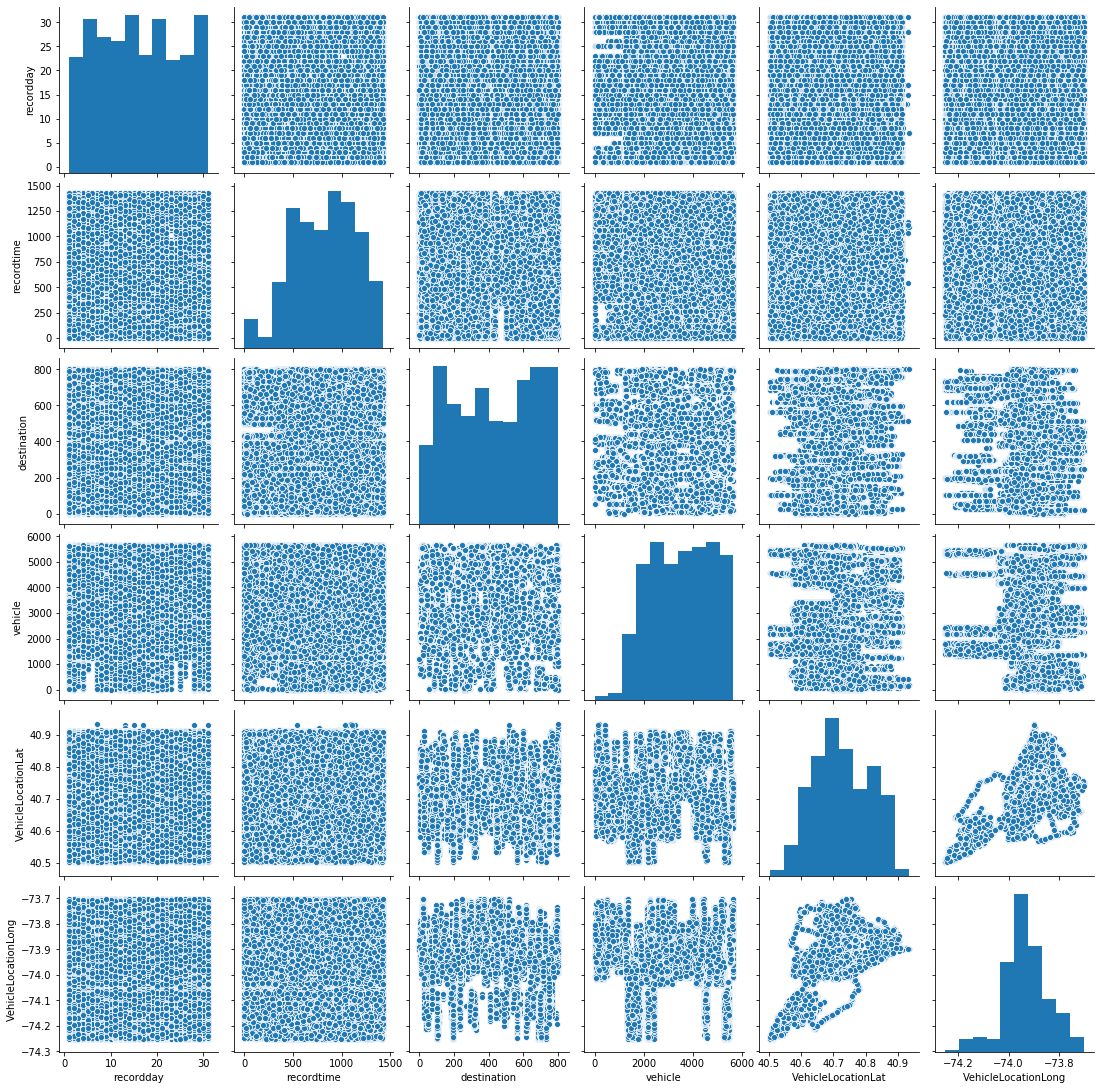

In [16]:
sns.pairplot(data=transport)
plt.show()

In [17]:
transport.head(4)

,recordday,recordtime,destination,vehicle,VehicleLocationLat,VehicleLocationLong
0,18,375,204,3858,40.802503,-73.930880
1,21,300,750,3774,40.807988,-73.946022
2,5,720,696,5374,40.586113,-74.084216
3,3,825,637,3601,40.868095,-73.919816


In [18]:
#Ready for Feature Engineering.
X = transport.copy()

# Feature Engineering

Use a min/max scalar to give the features the same range across the dateset. 

In [19]:
#scale the data.
scaler = MinMaxScaler()
X_mms = scaler.fit_transform(X)

### PCA 

Reducing the number of features to three using principle component analysis for use with the kmeans model. I conducted a quick search using six components to identify the minimum number of components that can be used to ensure I can account for at least 70% of the variance.

In [20]:
#principle component analysis, scree plot.
pca = PCA(n_components = 6) 
transit_pca = pca.fit_transform(X_mms)

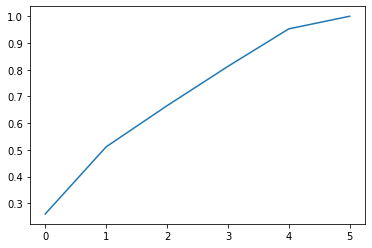

In [21]:
#Explained variance ratio on PCA. 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [22]:
#Four clusters will give 90% of the variance, but takes too long. 
#Attempt with three clusters.
pca = PCA(n_components = 3) 
transit_pca = pca.fit_transform(X_mms)

### T-SNE

A t-SNE dimension reduction set to three components is introduced for use with the dbscan model. 

In [23]:
#t-SNE
print("Start time: {}".format(datetime.datetime.now()))
tsne = TSNE(n_components=3,verbose=1)
transit_tsne = tsne.fit_transform(X_mms)
print("End time: {}".format(datetime.datetime.now()))

Start time: 2020-11-26 15:48:49.580324
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1033880 samples in 5.280s...
[t-SNE] Computed neighbors for 1033880 samples in 227.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1033880
[t-SNE] Computed conditional probabilities for sample 2000 / 1033880
[t-SNE] Computed conditional probabilities for sample 3000 / 1033880
[t-SNE] Computed conditional probabilities for sample 4000 / 1033880
[t-SNE] Computed conditional probabilities for sample 5000 / 1033880
[t-SNE] Computed conditional probabilities for sample 6000 / 1033880
[t-SNE] Computed conditional probabilities for sample 7000 / 1033880
[t-SNE] Computed conditional probabilities for sample 8000 / 1033880
[t-SNE] Computed conditional probabilities for sample 9000 / 1033880
[t-SNE] Computed conditional probabilities for sample 10000 / 1033880
[t-SNE] Computed conditional probabilities for sample 11000 / 1033880
[t-SNE] Computed conditional probabilities for samp

# K Means

Acquire the best silhouette score for ranges of k from two to ten.


*Note:*

Initially, I tried to predict and score across 1033880 records using six features. A little over three days went by and the process was not complete. We decided the best course of action would be to reduce the number of features to three using principle component analysis. At which point, I set up the code below to identify the bulk of the time completion to be in the scoring process.

I thought it might be fun to report the minimum amount of time that passed before the decision to downsample. Ideally I'd like the score to take under an hour because I'm running multiple iterations.

Silhouette Score Time Approximations at k = 2:

Full Size (1,033,880): Over four hours.

700,000: over eight hours.

500,000: over three hours.

250,000: over two hours. 

Results for 100,000 samples is below.

In [24]:
#k-means cluster using pca. 
scores = []
K = range(2,11) 
metric='minkowski'
goal = 0

#score on a sample
size = 100000
score_sample = random.sample(list(transit_pca), size)

print("Welcome to the KMeans Cluster Search on {} samples \n Start time: {}".format(size, datetime.datetime.now()))
print("*************************************************************************************")
for k in K: 

  #Building and fitting the model, date time and labels for knowing when a first cluster and silhouette score has completed. 
  print("Building cluster {} at {}".format(k, datetime.datetime.now()))   
  sample_pred = KMeans(n_clusters=k).fit_predict(score_sample)
  
  print("scoring the model at: {}".format(datetime.datetime.now()))
  score = metrics.silhouette_score(score_sample, sample_pred, metric=metric)
  #track for the max score.
  if score > goal:
    goal = score
    cluster = k
    print("best score so far is {} with a k of {}".format(goal, k))
  scores.append(score)
  print("-----")
print("Thank you for using the KMeans Cluster Search. End time: {}".format(datetime.datetime.now()))
print("*************************************************************************************")

Welcome to the KMeans Cluster Search on 100000 samples 
 Start time: 2020-11-26 17:00:35.216642
*************************************************************************************
Building cluster 2 at 2020-11-26 17:00:35.216642
scoring the model at: 2020-11-26 17:00:36.225188
best score so far is 0.2788136154318496 with a k of 2
-----
Building cluster 3 at 2020-11-26 17:27:06.133800
scoring the model at: 2020-11-26 17:27:07.781368
-----
Building cluster 4 at 2020-11-26 17:53:27.065256
scoring the model at: 2020-11-26 17:53:28.684929
best score so far is 0.2813701683656195 with a k of 4
-----
Building cluster 5 at 2020-11-26 18:19:53.720585
scoring the model at: 2020-11-26 18:19:56.004459
-----
Building cluster 6 at 2020-11-26 18:46:23.082618
scoring the model at: 2020-11-26 18:46:25.893107
-----
Building cluster 7 at 2020-11-26 19:12:55.231232
scoring the model at: 2020-11-26 19:12:58.981238
-----
Building cluster 8 at 2020-11-26 19:39:26.135135
scoring the model at: 2020-11-26 19:3

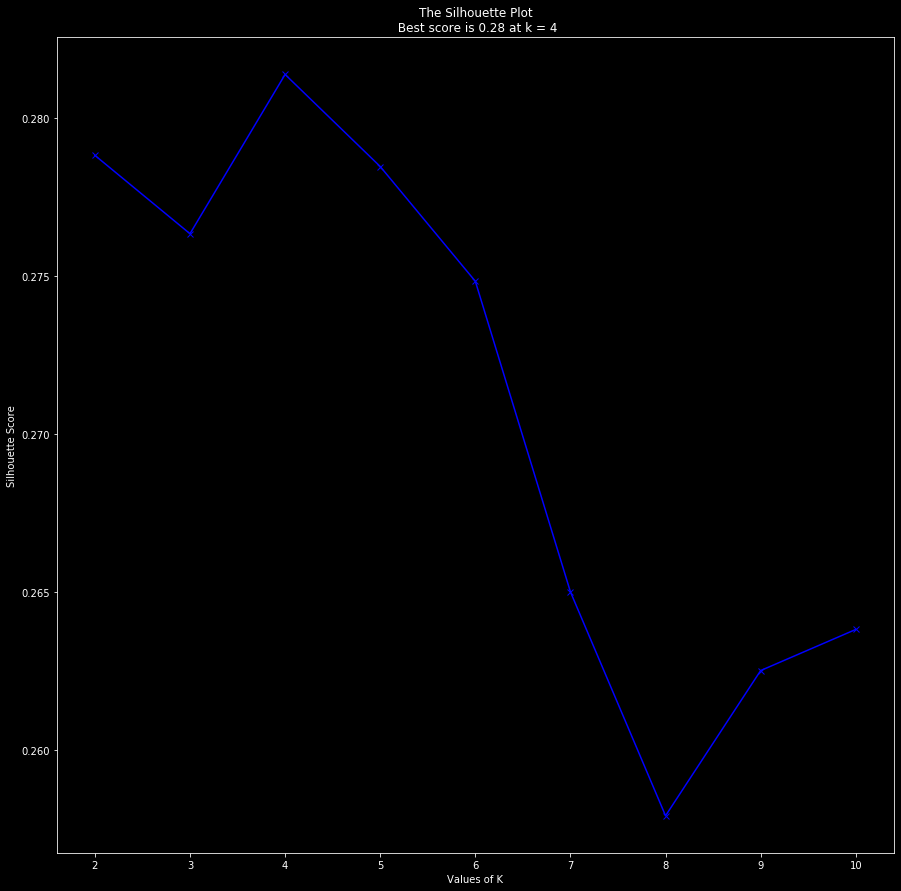

In [25]:

plt.style.use(['dark_background'])
plt.subplots(figsize=(15, 15))
plt.plot(K, scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.2f} at k = {}'.format(goal, cluster)) 
plt.show() 


In [26]:
#Run the model using highest score values against all records using best k value from sample.
kmeanModel = KMeans(n_clusters=cluster).fit(transit_pca) 
kClusters = kmeanModel.fit_predict(transit_pca)
 
#add kmeanas clusters to the original dataframe.
transit['kClusters'] = kClusters

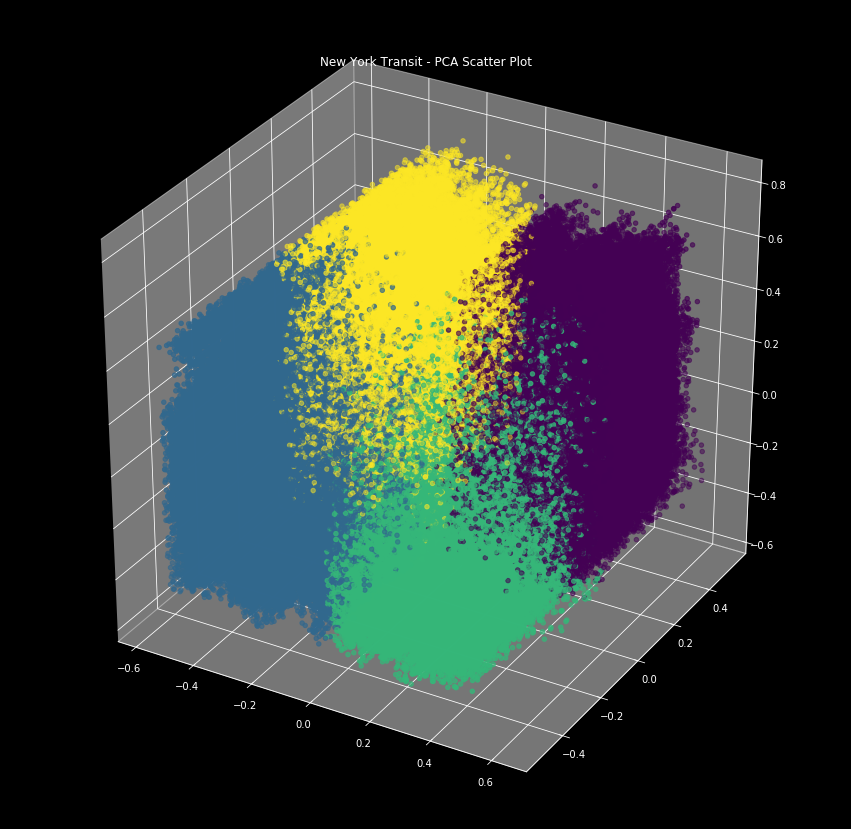

In [42]:
#visual.
# Creating figure
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")

    
# Creating plot
ax.scatter3D(transit_pca[:, 0], transit_pca[:,1], transit_pca[:,2], c=kClusters)
plt.title("New York Transit - PCA Scatter Plot")
 
# show plot
plt.show()

## K Means: How often are these clusters late?

While kMeans has little to reveal with regard to clusters, we can see that overall each cluster is late more often than not.

Regardless of the cluster we're looking at, we can see that the bus is more likely to be on time between midnight and 6:00 am. Otherewise, we can anticipate that it is going to be late.


In [636]:
late = transit.loc[(transit.DistanceFromStop == '0')| (transit.DistanceFromStop == 'at stop')].copy()
late['dScheduled'] = pd.to_datetime(late['ScheduledArrivalTime'], errors = 'coerce', format='%H:%M:%S')

In [637]:
time = pd.DatetimeIndex(late.RecordedAtTime)
time = time.strftime("%H:%M:%S")
late['dArrive'] = pd.to_datetime(time, format = '%H:%M:%S')

In [638]:
#You're late if the scheduled time is less than the arrival time. 
late['blate'] =late.dScheduled < late.dArrive 

In [639]:
#categorical record time range. 
bins = [0, 345, 705, 1065, 1425]
labels = ['Midnite-5:45', '6-11:45', 'Noon-17:45', '18-23:45']
transit['recordrange'] = pd.cut(transit.recordtime, bins, labels = labels,include_lowest = True)

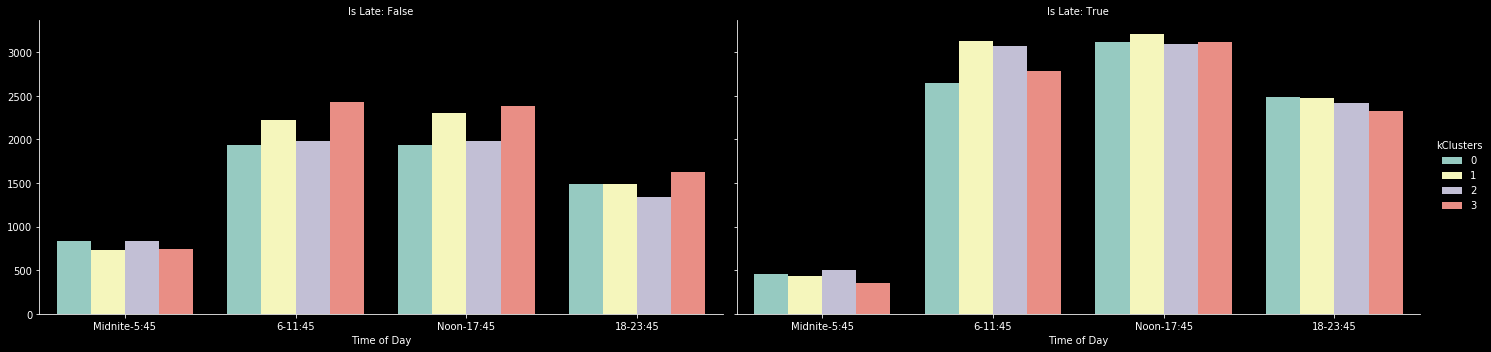

In [640]:
#The best graph that represnts the male and female make up. 
g = sns.catplot(x="recordrange", col="blate",
                data=late, kind="count", hue='kClusters',
                height=5, aspect=2)
(g.set_axis_labels("Time of Day", "")
  .set_titles("Is Late: {col_name}"))
plt.show()

# DB Scan 

DB Scan provides a memory error with when used with larger samples of this dataset.

A silhouette score will only compute for db scan with extremely small values of epsilon with this dataset.

In [363]:
#Silhouette Graph
scores = []

#different values of epsilon.
EPS = [0.00001, 0.00003, 0.000007]
EPS.sort
#minimum number of samples will equal the KNN clusters.
min_samples = 2
goal = 0

#score on a sample
size = 20000
score_sample = random.sample(list(transit_tsne), size)

print("Welcome to the DB Scan Epsilon Search on {} samples \n Start time: {}".format(size, datetime.datetime.now()))
print("*************************************************************************************")
for eps in EPS: 

  #Building and fitting the model 
  print("Building with epsilon {} at {}".format(eps, datetime.datetime.now())) 
  sample_pred =  DBSCAN(eps=eps, min_samples=min_samples).fit_predict(score_sample)
  
  print("scoring the model at: {}".format(datetime.datetime.now()))  
  #append the scores.
  score = metrics.silhouette_score(score_sample,sample_pred, metric=metric)
  #track for the max score.
  if score > goal:
    goal = score
    epsilon = eps
  scores.append(score)
  print("-----")
print("Thank you for using the DB Scan Epsilon Search End time: {}".format(datetime.datetime.now()))
print("*************************************************************************************")

Welcome to the DB Scan Epsilon Search on 20000 samples 
 Start time: 2020-11-27 23:46:13.130307
*************************************************************************************
Building with epsilon 1e-05 at 2020-11-27 23:46:13.130307
scoring the model at: 2020-11-27 23:46:14.401637
-----
Building with epsilon 3e-05 at 2020-11-27 23:47:17.387803
scoring the model at: 2020-11-27 23:47:23.457614
-----
Building with epsilon 7e-06 at 2020-11-27 23:48:26.916463
scoring the model at: 2020-11-27 23:48:27.612335
-----
Thank you for using the DB Scan Epsilon Search End time: 2020-11-27 23:49:30.401747
*************************************************************************************


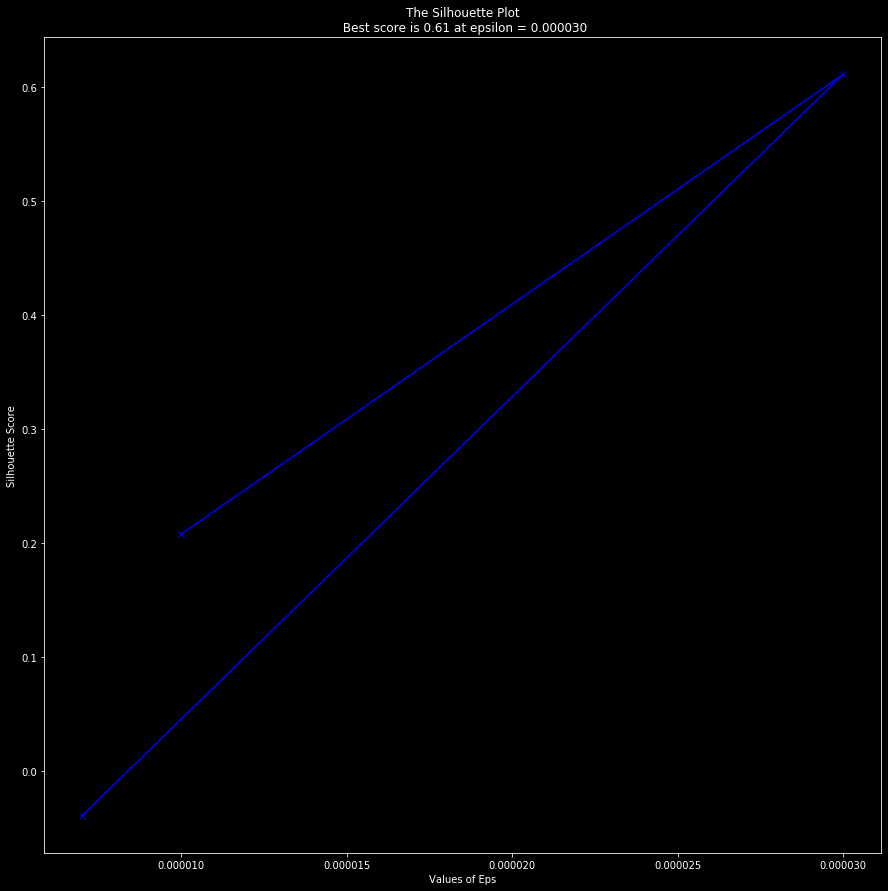

In [364]:
#Silhouette Graph
plt.style.use(['dark_background'])
plt.subplots(figsize=(15, 15))
plt.plot(EPS, scores, 'bx-') 
plt.xlabel('Values of Eps') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.02f} at epsilon = {:2f}'.format(goal, epsilon)) 
plt.show() 


In [460]:
#Run DB Scan the best espilon, with the the score_samples, so the model doesn't crash.
dbModel = DBSCAN(eps=epsilon, min_samples=min_samples)
dClusters = dbModel.fit_predict(score_sample)

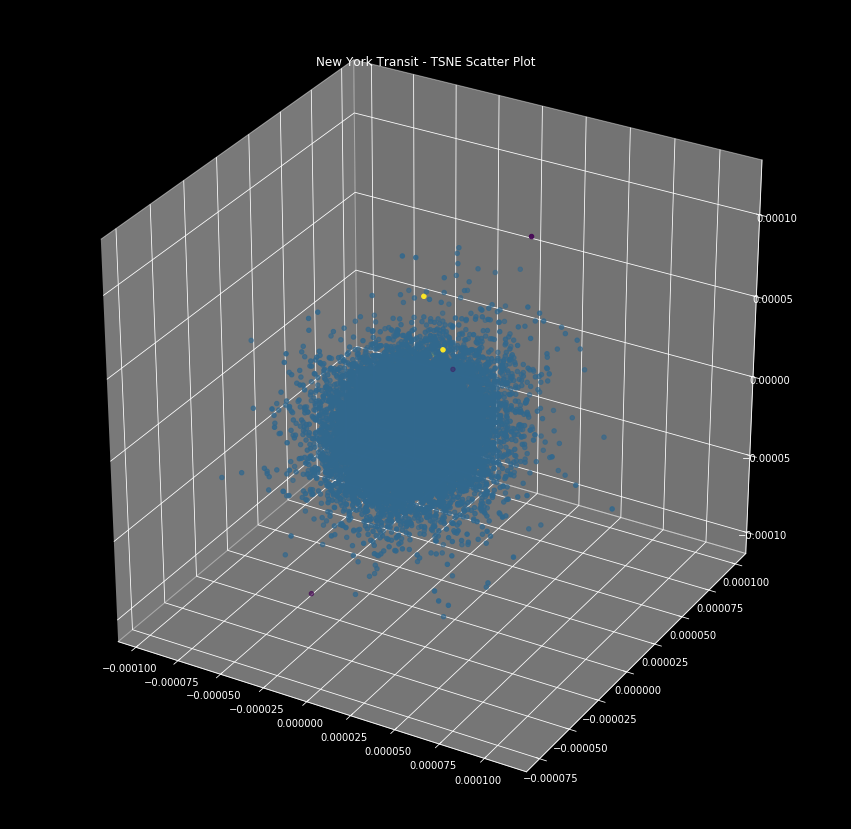

In [609]:
#visual.
# Creating figure
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
df_sample = pd.DataFrame(score_sample)
    
# Creating plot
ax.scatter3D(df_sample[0], df_sample[1], df_sample[2], c=dClusters)
plt.title("New York Transit - TSNE Scatter Plot")
 
# show plot
plt.show()

## DB Scan Results: Will the bus be late?

The graph and results from DBScan are quite similar to the KMeans solution. There appears to be very little evidence that any single factor contributes to the buses' timeliness other than the time of day.

Buses scheduled between 12:00 AM and 6:00 AM are more likely to be on time, otherwise they can be expected to be late. 

In [586]:
#the clusters are added to a dataframe. 
df_sample['dClusters'] = dClusters
scan_df = pd.concat([df_sample, transit], axis = 1)

#Select some columns to review.
scan_df = scan_df[[0,1,2, 'dClusters', "recordday", 'recordtime', 'destination', 'vehicle', 'VehicleLocationLat', 'VehicleLocationLong', 'DistanceFromStop', 'RecordedAtTime', 'ScheduledArrivalTime', 'recordrange']]

#Get the samples that are at the stop. 
scan_df = scan_df.loc[(scan_df.DistanceFromStop == '0') | (scan_df.DistanceFromStop == 'at stop')].copy()
scan_df = scan_df[scan_df.DistanceFromStop == '0'].dropna()
scan_df

,0,1,2,dClusters,recordday,recordtime,destination,vehicle,VehicleLocationLat,VehicleLocationLong,DistanceFromStop,RecordedAtTime,ScheduledArrivalTime,recordrange
3,2.580384e-06,-0.000015,0.000003,0.0,3,825,637,3601,40.868095,-73.919816,0,2017-12-03 13:50:23,13:52:00,Noon-17:45
9,3.729630e-07,-0.000027,0.000013,0.0,9,930,350,4435,40.735588,-73.716441,0,2017-12-09 15:31:48,15:26:57,Noon-17:45
19,-7.642597e-06,0.000013,0.000022,0.0,11,1110,677,4928,40.820520,-73.851537,0,2017-12-11 18:25:16,18:26:00,18-23:45
33,-1.207395e-05,0.000017,-0.000005,0.0,16,1215,634,4854,40.679388,-73.928944,0,2017-12-16 20:11:39,20:12:42,18-23:45
39,2.098455e-05,-0.000007,-0.000017,0.0,18,780,253,5223,40.729062,-73.781093,0,2017-12-18 12:54:56,12:49:00,Noon-17:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19796,-2.239741e-05,-0.000003,-0.000004,0.0,30,1080,333,2292,40.761547,-73.972902,0,2017-12-30 17:53:23,17:50:57,18-23:45
19820,-1.649446e-05,0.000030,0.000005,0.0,7,480,448,2577,40.689482,-73.969524,0,2017-12-07 07:57:23,07:53:00,6-11:45
19896,-4.694617e-05,0.000023,0.000020,0.0,12,1155,89,4585,40.647221,-73.779702,0,2017-12-12 19:17:16,18:58:00,18-23:45
19923,1.346177e-05,0.000023,-0.000003,0.0,14,225,549,2004,40.689451,-74.000569,0,2017-12-14 03:50:24,03:48:09,Midnite-5:45


In [587]:
#Convert the times and add a late indicator columns.
time = pd.DatetimeIndex(scan_df.RecordedAtTime)
time = time.strftime("%H:%M:%S")
scan_df['dArrive'] = pd.to_datetime(time, format = '%H:%M:%S')
scan_df['dScheduled'] = pd.to_datetime(scan_df['ScheduledArrivalTime'], errors = 'coerce', format='%H:%M:%S')

#You're late if the scheduled time is less than the arrival time. 
scan_df['blate'] =scan_df.dScheduled < scan_df.dArrive 

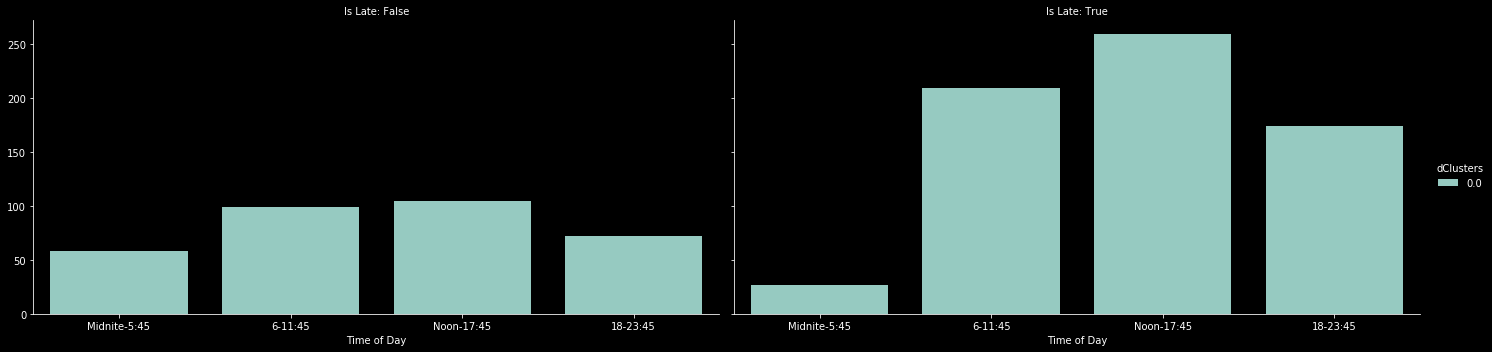

In [588]:
#Graph the categorical by whether or not the vehicle is late and the time of day.
g = sns.catplot(x="recordrange", col="blate",
                data=scan_df, kind="count", hue='dClusters',
                height=5, aspect=2)
(g.set_axis_labels("Time of Day", "")
  .set_titles("Is Late: {col_name}"))
plt.show()

# Which is the better model?


Both K-Means and DBScan are a good fit for this dataset. After working with both to conduct a series of evaluations, I found that k-Means will provide smaller clustering that is easier to work with when conducting an analysis. It also survived the feature complexity and large sample size, making it a better option for a general analysis. 

DBScan provides more clusters that are more specified. It also tends to failed to run with larger dimensionality and sample sizes. It performed better with location coordinates.

# Conclusion
***I'm thinking "you may want to adjust your schedules, but which schedules and by what amount?"***


With respect to all aspects that we can use from the New York City bus station, the time of day is a leading factor to the timeliness of the buses. 

Buses that are scheduled to arrive betwen midnight and 5:45 am are most likely to be on time.

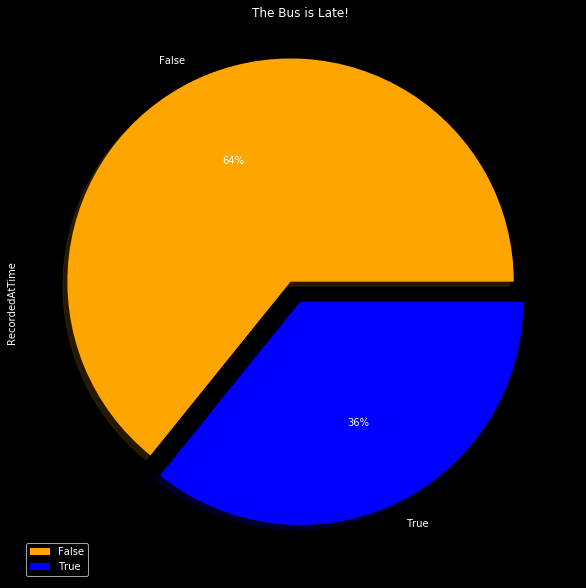

In [764]:
#Plot of late buses between midnight and 6 am. 
colors = ['orange', 'blue']
pie = late[late.recordrange == 'Midnite-5:45'].groupby(by='blate').agg('count')
pie.plot.pie(y='RecordedAtTime', figsize=(10,14), autopct='%.0f%%', colors=colors, explode=(0.1, 0), shadow=True)
plt.title("The Bus is Late!")
plt.show()

If I had the time, I'd grab all samples from the original 6 million datapoint set and filter based on the ones that are at the stop. 

I'd use these clustering techniques to analyze schedules and locations to identify factors that could improve adherence, similar to what I did on [Kaggle](https://www.kaggle.com/arosebudrejoicing/late-new-york-buses).  

It looks as though the scheduled arrival times are based upon driving times calculated with routes run between midnight and six am. 

I suggest using a prediction model against these datasets to predict the arrival time and readjust the schedule(s) from that analysis. 